<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day1/2_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression on CIFAR10

Now that we have seen how to load image data for classification and wrap it in a torch dataset, we will train simple classification models with pytorch.
In this notebook, we will start with [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)
that learns to classifiy the images based on the pixel values.
Note that logistic regression corresponds to an artificial neural network with a single, fully connected, layer.

Logistic regression is a linear model, so it can only learn linearly separable input output relations. Obviously, the pixel space is not linearly separable, so we do not expect this model to yield very good results. We will still start out from this to gently learn how to define models in pytorch.

## Preperation

In [1]:
# load tensorboard extension
# we will need this later in the notebook to monitor the training progress
%load_ext tensorboard

In [2]:
# import torch and other libraries
import os
import numpy as np
import torch
import torch.nn as nn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [ ]:
!pip install cifar2png

In [3]:
# check if we have gpu support
# colab offers free gpus, however they are not activated by default.
# to activate the gpu, go to 'Runtime->Change runtime type'. 
# Then select 'GPU' in 'Hardware accelerator' and click 'Save'
have_gpu = torch.cuda.is_available()
# we need to define the device for torch, yadda yadda
if have_gpu:
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

GPU is not available, training will run on the CPU


In [ ]:
# we refactor some codes from previous notebooks into a python file 'utils.py'
# to reuse it in later notebooks.
# run this in google colab to get the utils.py file
!wget https://raw.githubusercontent.com/constantinpape/training-deep-learning-models-for-vison/master/day1/utils.py 

In [4]:
# import the utils file
import utils

In [7]:
cifar_dir = './cifar10'
!cifar2png cifar10 cifar10

output dir `cifar10` already exists. Please specify a different output path


In [5]:
categories = os.listdir('./cifar10/train')
categories.sort()

## Prepare the data

We have already seen how to create a torch dataset for the cifar dataset in the previous notebook. We will repeat this here, but now split our data into training and validation data beforehand.

In [8]:
# load images and labels
images, labels = utils.load_cifar(os.path.join(cifar_dir, 'train'))

100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


In [9]:
# split the data into train and validation
# using 'train_test_split' from sklearn the data is shuffled and
# stratified, i.e. the same number of samples per classes 
# is present in the train and validation split
n_images = len(images)
(train_images, val_images,
 train_labels, val_labels) = train_test_split(images, labels, shuffle=True,
                                              test_size=0.15, stratify=labels)
assert len(train_images) == len(train_labels)
assert len(val_images) == len(val_labels)
assert len(train_images) + len(val_images) == n_images

print("Split cifar into training and validation data:")
print("Have", len(train_images), "training images and", len(val_images), "validation images")

Split cifar into training and validation data:
Have 42500 training images and 7500 validation images


In [10]:
# create the torch datasets for training and validation
from functools import partial

trafos = [utils.to_channel_first, utils.normalize, utils.to_tensor]
trafos = partial(utils.compose, transforms=trafos)

train_dataset = utils.DatasetWithTransform(train_images, train_labels,
                                           transform=trafos)

val_dataset = utils.DatasetWithTransform(val_images, val_labels,
                                         transform=trafos)

## Training and validation function

Now, we will write functions to train a model for one epoch and a function to validate it after an epoch.
Here, an `epoch` means iterating through the available training data once.

In order to monitor the progress during training, we will use [tensorboard](https://www.tensorflow.org/tensorboard).

In [11]:
def train(model, loader, 
          loss_function, optimizer,
          device, epoch,
          tb_logger, log_image_interval=100):
    """ Train model for one epoch.
    
    Parameters:
    model - the model we are training
    loader - the data loader that provides the training data
        (= pairs of images and labels)
    loss_function - the loss function that will be optimized
    optimizer - the optimizer that is used to update the network parameters
        by backpropagation of the loss
    device - the device used for training. this can either be the cpu or gpu
    epoch - which trainin eppch are we in? we keep track of this for logging
    tb_logger - the tensorboard logger, it is used to communicate with tensorboard
    log_image_interval - how often do we send images to tensborboard?
    """

    # set model to train mode
    model.train()
    
    # iterate over the training batches provided by the loader
    n_batches = len(loader)
    for batch_id, (x, y) in enumerate(loader):
       
        # send data and target tensors to the active device
        x = x.to(device)
        y = y.to(device)
        
        # set the gradients to zero, to start with "clean" gradients
        # in this training iteration
        optimizer.zero_grad()
        
        # apply the model to get the prediction
        prediction = model(x)
        
        # calculate the loss (negative log likelihood loss)
        # the loss function expects a 1d tensor, but we get a 2d tensor
        # with singleton second dimension, so we get rid of this dimension
        loss_value = loss_function(prediction, y[:, 0])
        
        # calculate the gradients (`loss.backward()`) 
        # and apply them to the model parameters with
        # to our optimizer (`optimizer.step()`)
        loss_value.backward()
        optimizer.step()
        
        # log the loss value to tensorboard
        step = epoch * n_batches + batch_id
        tb_logger.add_scalar(tag='train-loss', 
                             scalar_value=loss_value.item(),
                             global_step=step)
        
        # check if we log images, and if we do then send the
        # current image to tensorboard
        if log_image_interval is not None and step % log_image_interval == 0:
            tb_logger.add_images(tag='input', 
                                 img_tensor=x.to('cpu'),
                                 global_step=step)

In [12]:
# the validation function takes the model, runs prediction for
# all images provided by the loader and evaluates the results.
def validate(model, loader, loss_function, 
             device, step, tb_logger=None):
    """
    Validate the model predictions.
    
    Parameters:
    model - the model to be evaluated
    loader - the loader providing images and labels
    loss_function - the loss function
    device - the device used for prediction (cpu or gpu)
    step - the current training step. we need to know this for logging
    tb_logger - the tensorboard logger. if 'None', logging is disabled
    """
    # set the model to eval mode
    model.eval()
    n_batches = len(loader)
   
    # we record the loss and the predictions / labels for all samples
    mean_loss = 0
    predictions = []
    labels = []
    
    # the model parameters should not be updated during validation
    # torch.no_grad disables gradient updates in its scope
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)
            
            # update the loss 
            mean_loss += loss_function(prediction, y[:, 0]).item()
    
            # compute the most likely class predictions
            # note that 'max' returns a tuple with the 
            # index of the maximun value (which correponds to the predicted class)
            # as second entry
            prediction = prediction.max(1, keepdim=True)[1]

            # store the predictions and labels
            predictions.append(prediction[:, 0].to('cpu').numpy())
            labels.append(y[:, 0].to('cpu').numpy())
      
    # predictions and labels to numpy arrays
    predictions = np.concatenate(predictions)
    labels = np.concatenate(labels)
    
    # log the validation results if we have a tensorboard
    if tb_logger is not None:
        
        accuracy_error = 1. - metrics.accuracy_score(labels, predictions)
        mean_loss /= n_batches
        
        tb_logger.add_scalar(tag="validation-error",
                             global_step=step,
                             scalar_value=accuracy_error)
        tb_logger.add_scalar(tag="validation-loss",
                             global_step=step,
                             scalar_value=mean_loss)

    # return all predictions and labels for further evaluation
    return predictions, labels

## Model

In pytorch models are defined by a class that inherits from `nn.Module`.
This allows to add member variables (that are sub-classes of `nn.Module` themselves) so that these are handled correctly in auto differentiation.
The forward pass of a model is defined in the member function `forward`, the backward pass will be automatically generated.

Here, we define a simple network consisting of a single fully connected layer that receives the image as input.
When trained with cross entropy loss, this model corresponds to a logistic regressor.

In [13]:
# define logistic regression model
class LogisticRegressor(nn.Module):
    def __init__(self, n_pixels, n_classes):
        # the parent class 'nn.Module' needs to be initialised so
        # that all members that are subclasses of nn.Module themselves
        #  are correctly handled in autodiff
        super().__init__()
        self.n_pixels = n_pixels
        self.n_classes = n_classes
        # nn.Sequential applies its arguments one after the other 
        self.log_reg = nn.Sequential(
            # nn.Linear instantiates a fully connected layer, the first argument
            # specifies the number of input units, the second argument the number
            # of output units
            nn.Linear(self.n_pixels, self.n_classes),
            # logarithmic softmax activation.
            # the combination of LogSoftmax and negative log-likelihood loss
            # (see below) corresponds to training with Cross Entropy, but is
            # numerically more stable
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        # reshape the input to be 1d instead of 2d,
        # which is required for fully connected layers
        x = x.view(-1, self.n_pixels)
        x = self.log_reg(x)
        return x

## Training

Now we will put everything together and instantiate the model, loss function and run training and validation for a couple of epochs.

In [30]:
# instantiate the DataLoaders
# torch DataLoaders provide data from a dataset so that it can be ingested by the model.
# the most important aspect is that the data is stacked along the
# batch axis (which is the first axis in torch convention)
from torch.utils.data import DataLoader

# the loader for training: we train with 4 batches per sample
# and shuffle the data
batch_size = 8
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, 
                          shuffle=True)

# the loader for validation: we use a larger batch size and 
# don't need to shuffle the data
val_loader = DataLoader(val_dataset, batch_size=25)

In [23]:
# instantiate the loss function 
# here, we use the negative log likelihood loss
# combined with the LogSoftmax activation (see model definition)
# this corresponds to the CrossEntropy loss, but is numerically more stable
loss_function = nn.NLLLoss()
loss_function.to(device)

NLLLoss()

In [17]:
# this command will open tensorboard inside of our notebook
# click on the refresh symbol after the training (see below) has finished
# to see the training progress log
%tensorboard --logdir runs

In [19]:
# clear the tensorboard logs if they exist
# skip this step if you want to keep the logs of a previous run
from shutil import rmtree
try:
    rmtree('runs')
except OSError:
    pass

In [55]:
# instantiate the model
n_pixels = images[0].size  # number of pixels = 3 * 32 * 32
n_classes = 10    
model = LogisticRegressor(n_pixels, n_classes)

# with '.to' the parameters of the model (or any other subclass of torch.nn.Module)
# are sent to the specified device, which can be the cpu or a gpu
model.to(device)

LogisticRegressor(
  (log_reg): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [62]:
# we use stochastic gradient descent as optimizer
from torch.optim import SGD

# the most important parameter to the optimizer is the 
# learning rate, which is multiplied as a factor to the gradients during
# the parameter update
learning_rate=1.e-3

# we also set weight decay, which prevents very large weights
# by adding an L2 penalty for the paramerts to the loss
# this is a common regularization technique
weight_decay = 1.e-3

optimizer = SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

In [63]:
# instantiate the tensorboard logger that will be passed to the
# training and validation functions
# if you want to log a new experimnets, you should change the name
# of the directory to which the logs are written,
# e.g. by changing 'runs/log_reg1' to 'runs/log_reg2'
from torch.utils.tensorboard import SummaryWriter
tb_logger = SummaryWriter('runs/log_reg1')

In [64]:
# run training for a couple of epochs
from tqdm import trange  # progress bar for the overall training

# logistic regression is a very shallow model, so we don't need to 
# train the model for more than 1 or 2 epochs (seeing the data once or twice is enough)
# once we train deeper models, it will take longer for the training to converge and the number 
# of epochs needs to be increased
n_epochs = 2

for epoch in trange(n_epochs):
    train(model, train_loader, loss_function, optimizer,
          device, epoch, tb_logger=tb_logger)
    step = (epoch + 1) * len(train_loader)
    validate(model, val_loader, loss_function,
             device, step,
             tb_logger=tb_logger)

100%|██████████| 2/2 [00:20<00:00, 10.01s/it]


## Check the model on test data

Now that we have a trained model, we need to evaluate it on unseen data, i.e. data that was neither used for training the model nor validating it during training. For this, we will use the separate cifar10 test dataset.

To validate the model predictions we will compute the model accuracy and plot the confusion matrix, to get a sense of the types of errors made by the model.

In [26]:
test_images, test_labels = utils.load_cifar(os.path.join(cifar_dir, 'test'))

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


In [65]:
# we build a test dataset and loader and reuse the validation
# function to get all predictions and labels for our test-set
test_dataset = utils.DatasetWithTransform(test_images, test_labels,
                                          transform=trafos)
test_loader = DataLoader(test_dataset, batch_size=25)

test_predictions, test_labels = validate(model, test_loader, loss_function,
                                         device, 0, tb_logger=None)

Test accuracy
0.3964



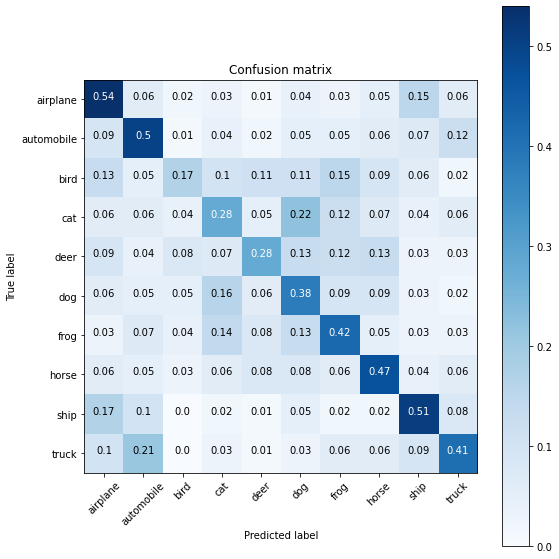

In [66]:
# to evaluate the model we compute the overall accuracy and 
# the class confusion matrix

accuracy = metrics.accuracy_score(test_labels, test_predictions)
print("Test accuracy")
print(accuracy)
print()

# we have implemented generating the confusion matrix in the utils already
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(test_labels,
                            test_predictions,
                            categories, ax)

## Tasks and Questions:

Tasks:
- Vary the learning rate and weight decay and see how this changes the loss and validation curves in the tensorboard and the performance on the test dataset. Remember to rename the log directory for the tensorboard logger before each run to get separate curves in the tensorboard.

Questions:
- What accuracy do the different models reach? Which parameter combination for the optimizer is the best?
- Which accuracy do you expect by guessing?
- Can you find any systematic errors from the confusion matrix?
